In [65]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Libraries

In [66]:
import os
import torch
import torchdiffeq
import matplotlib.pyplot as plt

from typing import cast
from pathlib import Path
from einops import rearrange, repeat
from torch import Tensor, FloatTensor
from omegaconf import OmegaConf, SCMode
from dataclasses import dataclass, asdict

from diffusers.models.autoencoders.vae import DecoderOutput
from diffusers.models.modeling_outputs import AutoencoderKLOutput
from diffusers.models.autoencoders.autoencoder_kl import AutoencoderKL

from flow_mnist.data import MNISTDataset
from flow_mnist.config import load_config
from flow_mnist.utils import plot_batch, image2norm, norm2image
from flow_mnist.flow import OTProbPath, MNISTSampleable, GaussianSampleable, LatentSampleable

Environment

In [67]:
torch.manual_seed(42)
os.chdir("..") if not os.path.exists("config.yaml") else None
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Project

In [68]:
config = load_config("config.yaml")
data = MNISTDataset(**asdict(config.data))

In [69]:
data_dist = MNISTSampleable(data)
norm_dist = GaussianSampleable((3, 32, 32))
prob_path = OTProbPath(p_init=norm_dist, p_data=data_dist)

In [70]:
# x_0 ~ p_init & x_1 ~ p_data
t = repeat(torch.linspace(0, 1, 20), 't -> t 1 1 1')
x_0 = norm_dist.sample(1)
x_1 = data_dist.sample(1)

### Visualize Optimal Transport Path using $p_{init} = \mathcal{N}(0,1)$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.9523523..4.1205125].


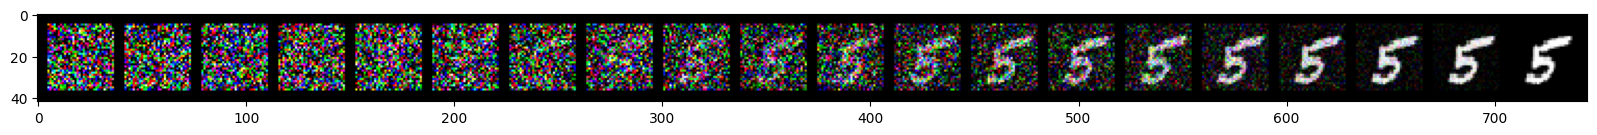

In [71]:
# p_init in [-1, 1] -> p_data in [0, 1]
x_t = prob_path.cond_prob_path(x_1, t)
plot_batch(x_t, nrow=t.size(0), figsize=(20, 5))

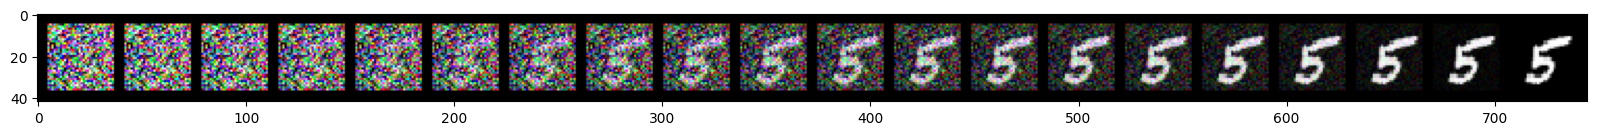

In [72]:
# p_init in [-1, 1] -> p_data in [-1, 1]
x_1_norm = image2norm(x_1)
x_t = prob_path.cond_flow(x_0, x_1_norm, t)
x_t = norm2image(x_t)
plot_batch(x_t, nrow=t.size(0), figsize=(20, 5))

### Visualize Optimal Transport Path using AutoEncoderKL Latents

In [73]:
# Create p_init & p_data
vae_kl = AutoencoderKL.from_pretrained(config.model.vae.repo).to(device)
latent_dist = LatentSampleable(dataset=data_dist, vae=vae_kl, scale=config.model.vae.scale)
latent_norm_dist = GaussianSampleable((4, 4, 4))

# Create ot prob path
prob_path = OTProbPath(p_init=latent_norm_dist, p_data=latent_dist)

Sample one latent and vizualize the conditional probability path $p_t(x|z)$

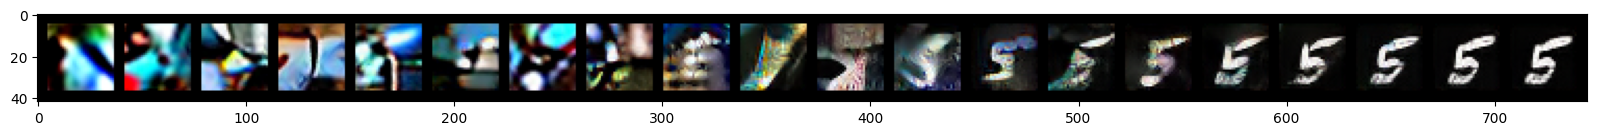

In [74]:
x_1_latent = latent_dist.encode(x_1.to(device))
x_t_latent = prob_path.cond_prob_path(x_1=x_1_latent, t=t.to(device))
x_t = latent_dist.decode(x_t_latent).cpu()
plot_batch(x_t, nrow=t.size(0), figsize=(20, 5))

Sample from the marginal probability path $p_t(x)$

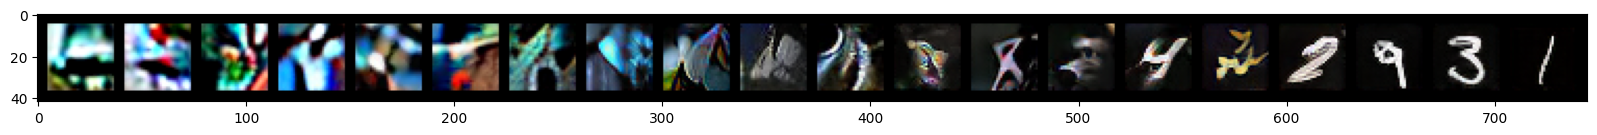

In [88]:
x_t_latent = prob_path.marg_prob_path(t=t.to(device))
x_t = latent_dist.decode(x_t_latent).cpu()
plot_batch(x_t, nrow=t.size(0), figsize=(20, 5))